# Distribution of Coalescent times under differing population histories

This is a notebook to outline problems I am having. WIll look at the function L and how it changes for different histories, and depending on how many lineages.

## Setup

These are the dependencies and functions needed, can skip over.

In [23]:
# dependencies

import os
from datetime import datetime
import argparse
import numpy as np
import pdb
import math#
import pandas as pd
from scipy.stats import entropy
import argparse
import matplotlib.pyplot as plt
import numpy as np
import msprime

# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In this notebook I record the observed sequence of tMRCAs along a genome, as returned by msprime. The following functions in the below code block are the mechanisms to do that.

In [69]:
def get_coal_data(sim,bin_length):
    tmrca_data = [] # first tuple is index, second tuple is sequence interval, third tuple is tMRCA
    ind = 0 #index for binning
    for tree in sim.trees():
        tmrca_data.append((tree.index,tree.interval[1],tree.time(tree.parent(0))))
        ind = math.floor(tree.interval[1]/bin_length)
    return tmrca_data

def round_bin_coal_data(seq_length,tmrca_data,bin_length):
    coal_times = np.zeros(shape=(int(seq_length/bin_length))) # create empty array which will store the binned coalescent times
    ind = 0 #index for binning
    for i in range(0,len(tmrca_data)):
        coal_times[ind:math.floor(tmrca_data[i][1]/bin_length)] = tmrca_data[i][2]
        ind = math.floor(tmrca_data[i][1]/bin_length)
    return coal_times

def round_coal_times(coal_times,T_scaled_np,N_T):
    # coal_times are the (exact) coalescent times along a sequence, as given by ms prime
    # T_scaled_np are the scaled time intervals (in a np aray)
    # N_T is the number of hidden states
    coal_times_intervals = [] 
    for i in range(0,len(coal_times)):
        diff = coal_times[i] - T_scaled_np
        diff_pos = diff[diff >0]
        where = np.argmin(diff_pos) # find closest interval
        if where == N_T: #TODO find a better fix for this. Have extended T to include upper interval
            where = where - 1
        coal_times_intervals.append(where) 
    return coal_times_intervals

def num_occcurences(array,time_intervals):
    counts = np.zeros(shape=len(time_intervals))
    for i in range(len(array)):
        counts[array[i]] += 1
    return counts

def get_counts_freq(sim,time_intervals,bin_length):
    # this function returns the observed pdf of T2 (f_T2(t))

    # get true coalescent data
    tmrca_data = get_coal_data(sim, bin_length) 

    # round this data into segments of size args.bin_length 
    coal_times = round_bin_coal_data(sim.sequence_length,tmrca_data, bin_length) # partition coalescent data into bins  


    # round coalescence time into interval
    coal_times_intervals = np.array(round_coal_times(coal_times,time_intervals,N_T=len(time_intervals))) # round binned coalescent times into their respected interval

    # count number of occurunces in each interval
    counts = num_occcurences(coal_times_intervals,time_intervals)

    # get frequency of these (divide by sum). This is the pdf (=f_T2(t))
    counts_freq = counts / counts.sum()
    return counts_freq

def split(N,mig_prop,T_1,T_2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

def split_withpsc2a(N,mig_prop,T_1,T_2,alpha1,alpha1a,alpha2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.PopulationParametersChange(time=0, initial_size=N*alpha1),
        msprime.PopulationParametersChange(time=T_1, initial_size=N),        
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.PopulationParametersChange(time=T_1, initial_size=N*alpha1a),
        msprime.PopulationParametersChange(time=T_1a, initial_size=N*alpha2),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1),
        msprime.PopulationParametersChange(time=T_2, initial_size=N)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

# mechanics of getting things working


In [70]:

min_time = 0
max_time = 3e+05
spacing = 1000
bin_length = 100
seq_length = 150e+06
time_intervals = np.arange(min_time,max_time,spacing)

# scaling
scaling = 250*len(time_intervals)*(bin_length/seq_length)

## Panmictic population of constant size

In [12]:
def panmictic_const(seq_length,N=10000,sample_size=2):
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=sample_size, initial_size=N, growth_rate=0)]
    migration_matrix = [[0]]
    demographic_events =[]
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,migration_matrix=migration_matrix,
        demographic_events=demographic_events)

    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,mutation_rate=2e-08)
    return sim

In [13]:
# run simulation
seq_length = 150e+06


print("Running simulation")
sim0 = panmictic_const(seq_length,N=10000,sample_size=2)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Simulation finished


Now record the observations, using the functions we defined earlier.

In [16]:
f_obs0 = get_counts_freq(sim0,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs0 = [sum(f_obs0[0:t]) for t in range(len(f_obs0))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs0 = [spacing*(1-F_obs0[i])/(2*f_obs0[i]) for i in range(len(f_obs0)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


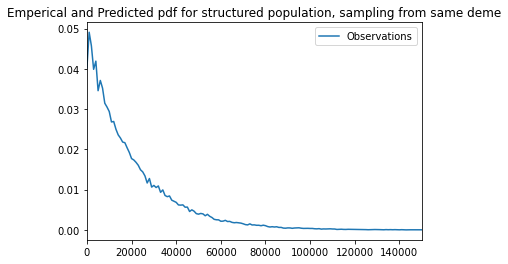

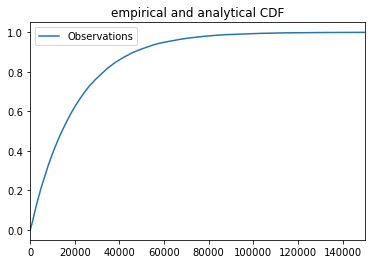

No handles with labels found to put in legend.


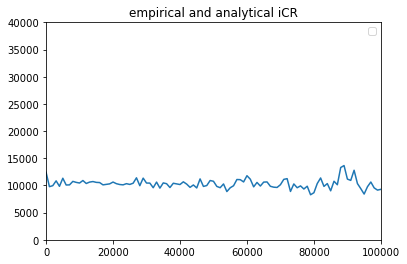

In [19]:
line_f_obs0 = plt.plot(time_intervals,f_obs0,label="Observations")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()

line_F_obs0 = plt.plot(time_intervals,F_obs0,label="Observations")
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs0 = plt.plot(time_intervals,iCR_obs0)
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

In [20]:
scaling

0.05

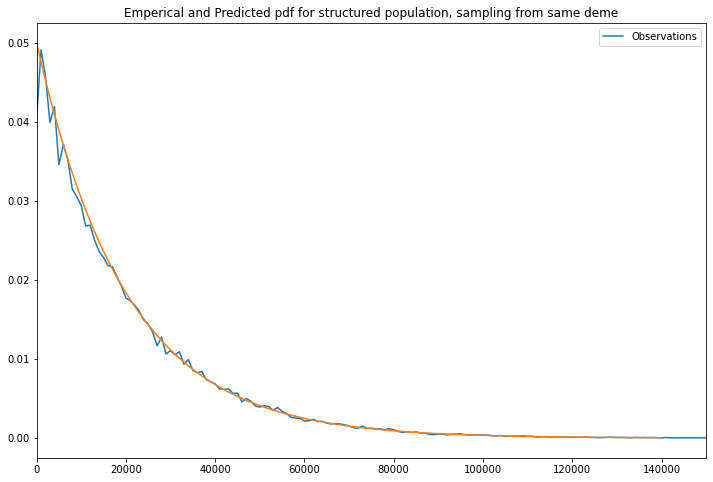

In [25]:
def f(x,N):
    L = np.exp(-x/(2*N))
    f = 1
    return f*L*scaling
    
time_array = np.arange(0,140000,1)

line_f_obs0 = plt.plot(time_intervals,f_obs0,label="Observations")
plt.plot(time_array,f(time_array,10000))
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()


### Structured pop of constant size


In [29]:
N_0 = 10000
T_1= 20000
T_2= 40000
gamma = 0.3
seq_length=150e+06
print('T_1 and T_2 are {}'.format([T_1,T_2]))
print('gamma is {}'.format(gamma))
sim2 = split(N_0,gamma,T_1,T_2,seq_length)

T_1 and T_2 are [20000, 40000]
gamma is 0.3
N is 10000
mig_prop is 0.3
t_1 is 20000 and t_2 is 40000
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Mass migration: Lineages moved with probability 0.3 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 20000.0 -- 40000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 40000.0
   - Mass migration: Lineages moved with probability 1 back

In [30]:
 f_obs2 = get_counts_freq(sim2,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs2 = [sum(f_obs2[0:t]) for t in range(len(f_obs2))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs2 = [spacing*(1-F_obs2[i])/(2*f_obs2[i]) for i in range(len(f_obs2)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


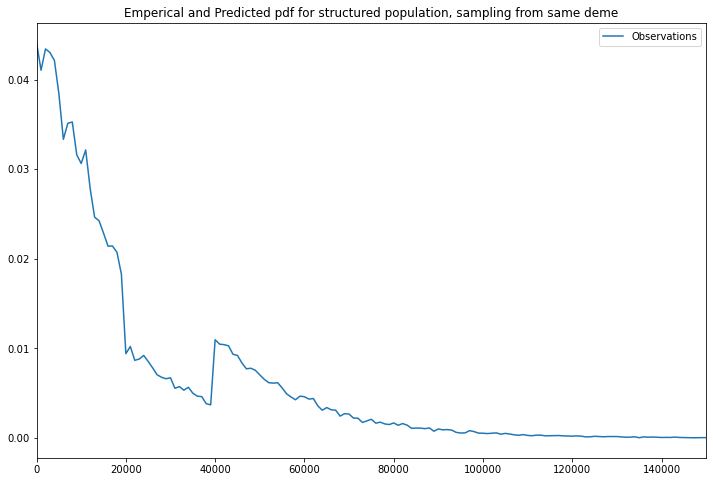

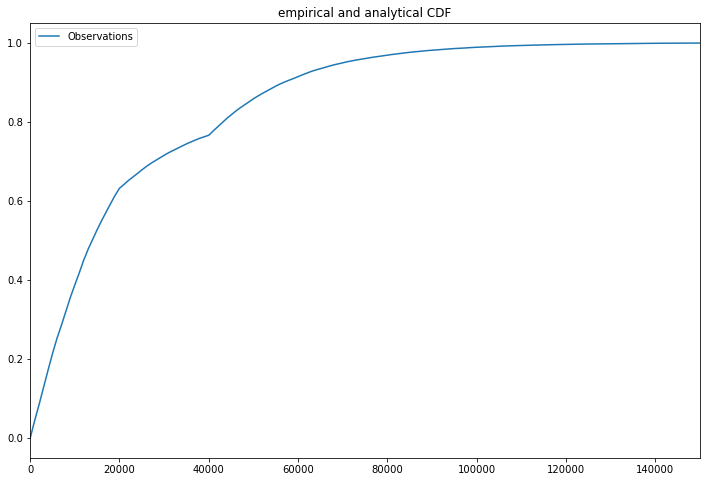

No handles with labels found to put in legend.


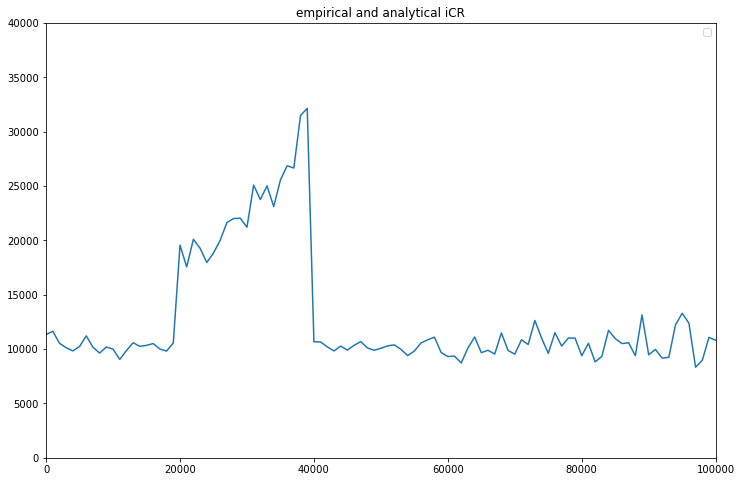

In [31]:
line_f_obs2 = plt.plot(time_intervals,f_obs2,label="Observations")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()

line_F_obs2 = plt.plot(time_intervals,F_obs2,label="Observations")
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,150000)
plt.show()

line_ICR_obs2 = plt.plot(time_intervals,iCR_obs2)
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

N, T_1, T_2, and gamma exist and are [10000, 20000, 40000, 0.3]


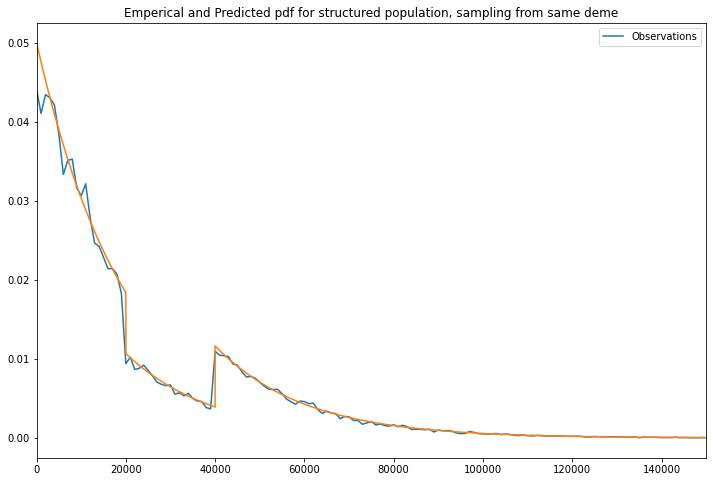

In [44]:
def f(x,N,T_1,T_2,gamma):
#     x = x/(2*N)
#     T_1 = T_1/(2*N)
#     T_2 = T_2/(2*N)
    if x<T_1:
        L = np.exp(-x/(2*N))
        f = 1
    elif x>=T_1 and x<T_2:
        L = np.exp(-T_1/(2*N))*((gamma**2)*np.exp(-(x-T_1)/(2*N)) + ((1-gamma)**2)*np.exp(-(x-T_1)/(2*N)))
        f = 1
    elif x>=T_2:
        sigma = (gamma**2) + ((1-gamma)**2)
        L = np.exp(-T_1/(2*N))*(1-sigma+(gamma**2)*np.exp(-(T_2-T_1)/(2*N)) + ((1-gamma)**2)*np.exp(-(T_2-T_1)/(2*N)))*(np.exp(-(x-T_2)/(2*N)))
        f = 1
    else:
        print('misunderstanding')
    return f*L*scaling
    
time_array = np.arange(0,160000,1)
N = 10000
print('N, T_1, T_2, and gamma exist and are {}'.format([N,T_1,T_2,gamma]))
f_theory = [f(i,N,T_1,T_2,gamma) for i in time_array]
line_f_obs0 = plt.plot(time_intervals,f_obs2,label="Observations")
plt.plot(time_array,f_theory)
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()


In [34]:
T_2

40000

### Structured pop of changing size


In [71]:
N = 10000
mig_prop = 0.2
T_1 = 20000
T_1a = 30000
T_2 = 40000
alpha1 = 1
alpha1a = 3
alpha2 = 2
seq_length = 150e+06

sim3 = split_withpsc2a(N,mig_prop,T_1,T_2,alpha1,alpha1a,alpha2,seq_length)

N is 10000
mig_prop is 0.2
t_1 is 20000 and t_2 is 40000
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Events @ generation 0
   - Population parameter change for -1: initial_size -> 10000 
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Epoch: 0.0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 10000 
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forward

In [72]:
f_obs3 = get_counts_freq(sim3,time_intervals,bin_length) # empirical pdf for non panmictic history, with constant structure and constant size
F_obs3 = [sum(f_obs3[0:t]) for t in range(len(f_obs3))] # this returns the CDF of T2 ( F_T2(t) )
iCR_obs3 = [spacing*(1-F_obs3[i])/(2*f_obs3[i]) for i in range(len(f_obs3)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)


/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


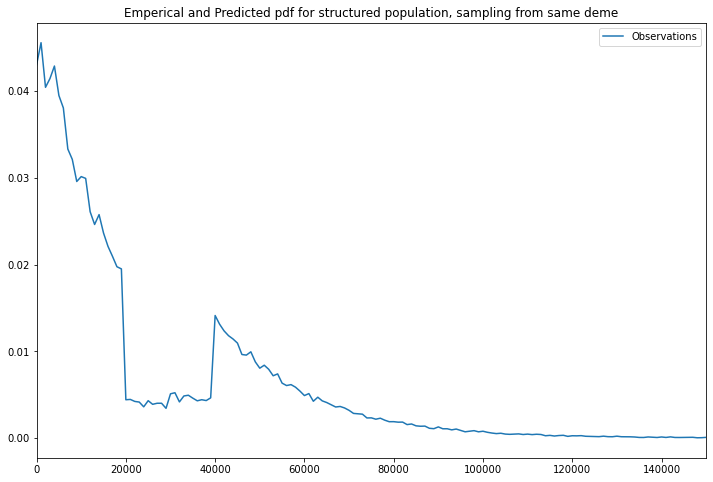

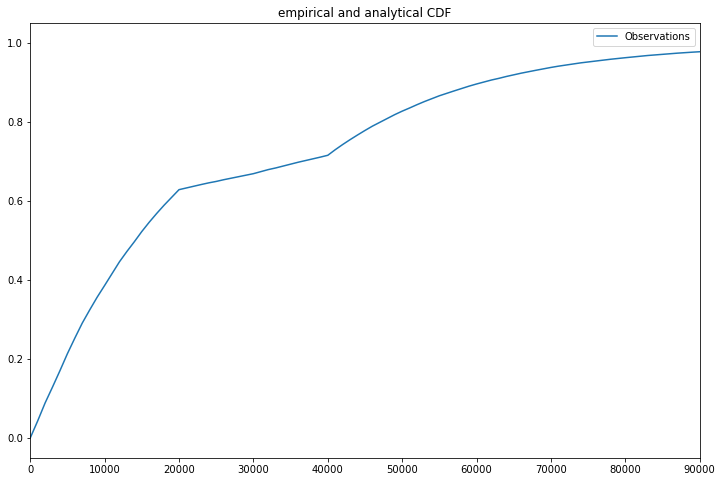

No handles with labels found to put in legend.


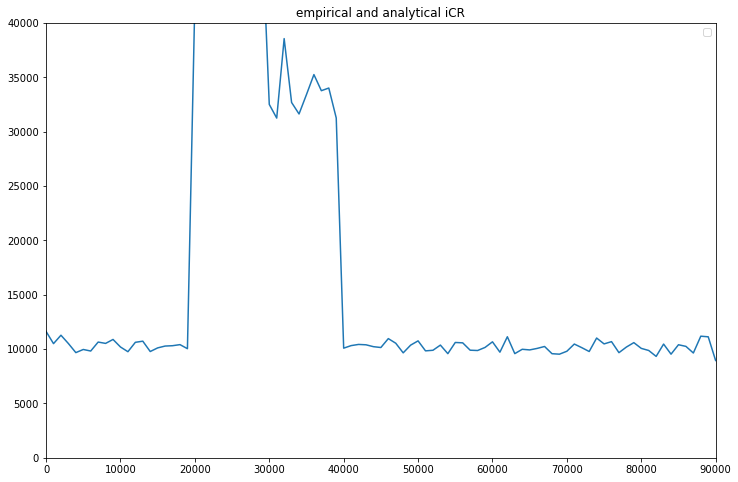

In [73]:
line_f_obs3 = plt.plot(time_intervals,f_obs3,label="Observations")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()

line_F_obs3 = plt.plot(time_intervals,F_obs3,label="Observations")
plt.title('empirical and analytical CDF')
plt.legend()
plt.xlim(0,90000)
plt.show()

line_ICR_obs3 = plt.plot(time_intervals,iCR_obs3)
plt.xlim(0,90000)
plt.ylim(0,40000)
plt.legend()
plt.title('empirical and analytical iCR')
plt.show()

N, T_1,T_1a, T_2, and gamma exist and are [10000, 20000, 30000, 40000, 0.2]
alpha1,alpha2 and alpha1a are [1, 2, 3]


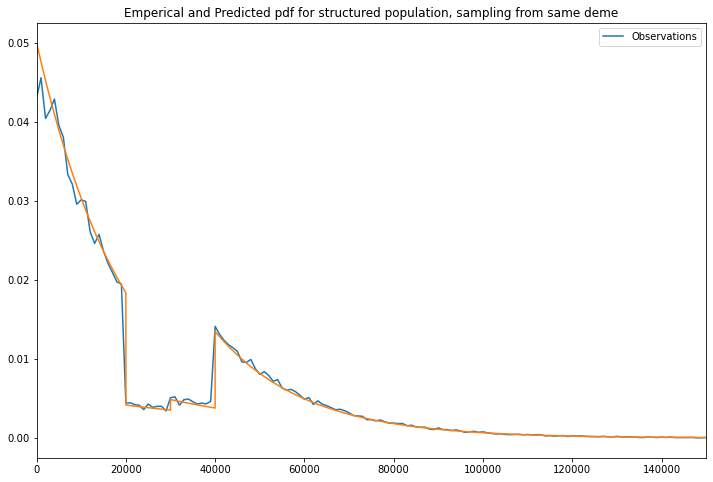

In [95]:
def f(x,N,T_1,T_2,gamma,alpha1,alpha1a,alpha2):
#     x = x/(2*N)
#     T_1 = T_1/(2*N)
#     T_2 = T_2/(2*N)
    if x<T_1:
        L = np.exp(-x/(2*N))
        f = 1
    elif x>=T_1 and x<T_1a:
        L = np.exp(-T_1/(2*N))*((gamma**2)*np.exp(-(1/alpha1a)*(x-T_1)/(2*N)) + ((1-gamma)**2)*np.exp(-(1/alpha1a)*(x-T_1)/(2*N)))
        f = 1/alpha1a
    elif x>=T_1a and x<T2:
        L = np.exp(-T_1/(2*N))*((gamma**2)*np.exp(-(1/alpha2)*(x-T_1)/(2*N)) + ((1-gamma)**2)*np.exp(-(1/alpha2)*(x-T_1)/(2*N)))
        f = 1/alpha2
    elif x>=T_2:
        sigma = (gamma**2) + ((1-gamma)**2)
        L = np.exp(-T_1/(2*N))*(1-sigma+(gamma**2)*np.exp(-(1/alpha2)*(T_2-T_1)/(2*N)) + ((1-gamma)**2)*np.exp(-(1/alpha2)*(T_2-T_1)/(2*N)))*(np.exp(-(x-T_2)/(2*N)))
        f = 1
    else:
        print('misunderstanding')
    return f*L*scaling
    
time_array = np.arange(0,160000,1)
N = 10000
gamma = 0.2
print('N, T_1,T_1a, T_2, and gamma exist and are {}'.format([N,T_1,T_1a,T_2,gamma]))
print('alpha1,alpha2 and alpha1a are {}'.format([alpha1,alpha2,alpha1a]))
f_theory = [f(i,N,T_1,T_2,gamma,alpha1,alpha1a,alpha2) for i in time_array]
line_f_obs0 = plt.plot(time_intervals,f_obs3,label="Observations")
plt.plot(time_array,f_theory)
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()


N, T_1,T_1a, T_2, and gamma exist and are [10000, 20000, 30000, 40000, 0.2]
alpha1,alpha2 and alpha1a are [1, 2, 3]


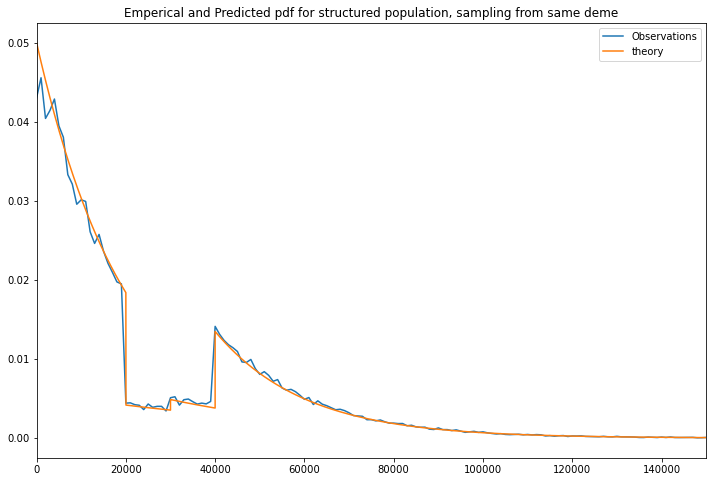

In [97]:
def f(x,N,T_1,T_2,gamma,alpha1,alpha1a,alpha2):
#     x = x/(2*N)
#     T_1 = T_1/(2*N)
#     T_2 = T_2/(2*N)
    if x<T_1:
        L = np.exp(-x/(2*N))
        f = 1
    elif x>=T_1 and x<T_1a:
        L = np.exp(-T_1/(2*N))*((gamma**2)*np.exp(-(1/alpha1a)*(x-T_1)/(2*N)) + ((1-gamma)**2)*np.exp(-(1/alpha1a)*(x-T_1)/(2*N)))
        f = 1/alpha1a
    elif x>=T_1a and x<T2:
        L = np.exp(-T_1/(2*N))*((gamma**2)*np.exp(-(1/alpha2)*(x-T_1)/(2*N)) + ((1-gamma)**2)*np.exp(-(1/alpha2)*(x-T_1)/(2*N)))
        f = 1/alpha2
    elif x>=T_2:
        sigma = (gamma**2) + ((1-gamma)**2)
        L = np.exp(-T_1/(2*N))*(1-sigma+(gamma**2)*np.exp(-(1/alpha2)*(T_2-T_1)/(2*N)) + ((1-gamma)**2)*np.exp(-(1/alpha2)*(T_2-T_1)/(2*N)))*(np.exp(-(x-T_2)/(2*N)))
        f = 1
    else:
        print('misunderstanding')
    return f*L*scaling
    
time_array = np.arange(0,160000,1)
N = 10000
gamma = 0.2
print('N, T_1,T_1a, T_2, and gamma exist and are {}'.format([N,T_1,T_1a,T_2,gamma]))
print('alpha1,alpha2 and alpha1a are {}'.format([alpha1,alpha2,alpha1a]))
f_theory = [f(i,N,T_1,T_2,gamma,alpha1,alpha1a,alpha2) for i in time_array]
line_f_obs0 = plt.plot(time_intervals,f_obs3,label="Observations")
plt.plot(time_array,f_theory,label="theory")
plt.legend()
plt.xlim(0,150000)
plt.title('Emperical and Predicted pdf for structured population, sampling from same deme')
plt.show()
